In [20]:
%matplotlib widget

import numpy as np
from scipy.signal import savgol_filter
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap

from hnn_core.network import pick_connection
from hnn_core.cell import _get_gaussian_connection

from plot_simulate_rep_L6 import sim_dev_spiking, plot_dev_spiking_v2

Proportion of network driven on std: 0.140625
# driven units (Group 1) on std: 18.0
# driven units (Group 2) on std: 9.0
simulating fully-connected network
MPI will run 10 trial(s) sequentially by distributing network neurons over 10 processes.
numprocs=10
/home/ryan/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/ryan/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/ryan/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/ryan/anaconda3/envs/hnn_core/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https:/

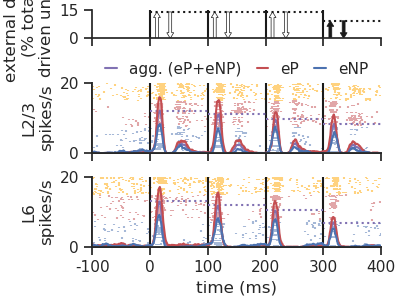

In [2]:
dev_magnitude = -1
n_trials = 10
rng = np.random.default_rng(1234)
burn_in_time = 300.0
n_procs = 10
record_vsec = False

net, drive_params = sim_dev_spiking(dev_magnitude=dev_magnitude,
                                    n_trials=n_trials,
                                    burn_in_time=burn_in_time,
                                    n_procs=n_procs,
                                    record_vsec=record_vsec,
                                    rng=rng)

rep_start_times = drive_params['rep_times']
drive_times = drive_params['drive_times']
drive_strengths = drive_params['drive_strengths']
tstop = drive_params['tstop']

fig_dev_spiking_v2, spike_rates = plot_dev_spiking_v2(net,
                                                      burn_in_time,
                                                      rep_start_times,
                                                      drive_times,
                                                      drive_strengths,
                                                      tstop,
                                                      return_spike_rates=True)

In [3]:
def syn_conductance_kernel(t_vec, tau1=10., tau2=20.):
    tp = (tau1 * tau2) / (tau2 - tau1) * np.log(tau2 / tau1)
    norm_factor = 1 / (-np.exp(-tp / tau1) + np.exp(-tp / tau2))
    G = norm_factor * (-np.exp(-t_vec / tau1) + np.exp(-t_vec / tau2))
    return G


def get_conductance_timecourse(net, cell_types, receptor, src_types=None):
    times = net.cell_response.times
    inplane_dist = net._inplane_distance
    spike_times = net.cell_response.spike_times
    spike_gids = net.cell_response.spike_gids
    n_trials = len(spike_times)
    c_total_by_type = dict()

    for cell_type in cell_types:
        gids = net.gid_ranges[cell_type]
        c_total = np.zeros((len(gids), len(times)))
        # get GABAA connections to the desired cell type
        conn_idxs = pick_connection(net, src_gids=src_types,
                                    target_gids=cell_type, receptor=receptor)
        for conn_idx in conn_idxs:
            nc_dict = net.connectivity[conn_idx]['nc_dict']
            src_type = net.connectivity[conn_idx]['src_type']
            receptor = net.connectivity[conn_idx]['receptor']
            tau1 = net.cell_types[cell_type].synapses[receptor]['tau1']
            tau2 = net.cell_types[cell_type].synapses[receptor]['tau2']
            gid_pairs = net.connectivity[conn_idx]['gid_pairs'].items()
            # print(f'{cell_type}: tau 1 {tau1}, tau2 {tau2}')
            # for each source, find spikes and map their responses to targets
            for src_gid, targ_gids in gid_pairs:
                src_gid_idx = np.nonzero(
                    np.in1d(src_gid, net.gid_ranges[src_type]))[0][0]
                src_pos = net.pos_dict[src_type][src_gid_idx]

                # get all source spike times
                for trial_idx in range(n_trials):
                    spike_idxs = np.nonzero(
                        np.array(spike_gids[trial_idx]) == src_gid)[0]
                    src_spike_times = np.array(spike_times[trial_idx])
                    src_spike_times = src_spike_times[spike_idxs]
                    # get time window following each spike
                    for src_spike_time in src_spike_times:
                        time_after_idxs = times >= src_spike_time
                        # time samples after the spike occured
                        times_after = times[time_after_idxs]
                        times_after -= times_after[0]
                        # for each spike time, get target information,
                        # calculate post-synaptic response, and add to
                        # cumulative post-synaptic conductance timecourse
                        for targ_gid in targ_gids:
                            targ_gid_idx = np.nonzero(
                                np.in1d(targ_gid,
                                        net.gid_ranges[cell_type]))[0][0]
                            targ_pos = net.pos_dict[cell_type][targ_gid_idx]
                            g_bar, _ = _get_gaussian_connection(src_pos,
                                                                targ_pos,
                                                                nc_dict,
                                                                inplane_dist)
                            post_syn_cond = g_bar * syn_conductance_kernel(
                                times_after, tau1=tau1, tau2=tau2
                            )
                            c_total[targ_gid_idx,
                                    time_after_idxs] += post_syn_cond
        c_total_by_type[cell_type] = c_total

    return c_total_by_type

In [4]:
# calculate & prepare avg conductance vectors for plotting
# all GABAergic conductances on L2/3 e cells
c_total_by_type = get_conductance_timecourse(net,
                                             cell_types=['L2e_1', 'L2e_2'],
                                             receptor=['gabaa', 'gabab'],
                                             src_types=None)
# L6-induced GABAergic conductances on L2/3 e cells
c_total_by_type_L6 = get_conductance_timecourse(net,
                                                cell_types=['L2e_1', 'L2e_2'],
                                                receptor=['gabaa', 'gabab'],
                                                src_types=['L6i_1', 'L6i_2'])

times = net.cell_response.times
n_trials = len(net.cell_response.spike_times)
post_burn_in_idxs = times >= burn_in_time
times_post_burn_in = times[post_burn_in_idxs] - burn_in_time

g_1_avg = c_total_by_type['L2e_1'].mean(axis=0) / n_trials
g_1_avg = g_1_avg[post_burn_in_idxs]
g_2_avg = c_total_by_type['L2e_2'].mean(axis=0) / n_trials
g_2_avg = g_2_avg[post_burn_in_idxs]

g_1_avg_L6 = c_total_by_type_L6['L2e_1'].mean(axis=0) / n_trials
g_1_avg_L6 = g_1_avg_L6[post_burn_in_idxs]
g_2_avg_L6 = c_total_by_type_L6['L2e_2'].mean(axis=0) / n_trials
g_2_avg_L6 = g_2_avg_L6[post_burn_in_idxs]

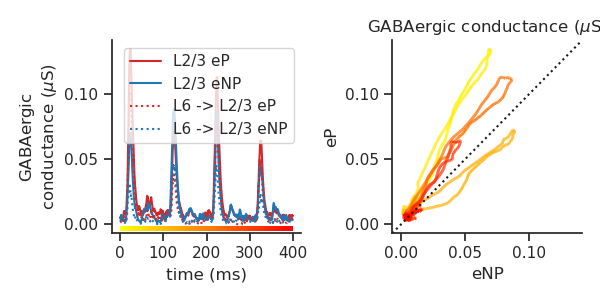

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].plot(times_post_burn_in, g_1_avg, c='tab:red')
axes[0].plot(times_post_burn_in, g_2_avg, c='tab:blue')
axes[0].plot(times_post_burn_in, g_1_avg_L6, c='tab:red', ls=':')
axes[0].plot(times_post_burn_in, g_2_avg_L6, c='tab:blue', ls=':')
axes[0].set_xticks(np.arange(0, times_post_burn_in[-1], 100.0))
axes[0].set_ylabel('$\mathregular{GABA}$ergic\nconductance ($\mu$S)')
axes[0].set_xlabel('time (ms)')
axes[0].legend(['L2/3 eP', 'L2/3 eNP', 'L6 -> L2/3 eP', 'L6 -> L2/3 eNP'])
cax = axes[0].inset_axes([0.0, -0.005, 400, 0.004], transform=axes[0].transData)

# Create a set of line segments so that we can color them individually
# This creates the points as an N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([g_2_avg, g_1_avg]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(times_post_burn_in.min(), times_post_burn_in.max())
lc = LineCollection(segments, cmap='autumn_r', norm=norm)
# Set the values used for colormapping
lc.set_array(times_post_burn_in)
lc.set_linewidth(2)
line = axes[1].add_collection(lc)
# place colorbar along x-axis of 1st plot
cbar = fig.colorbar(line, cax=cax, orientation='horizontal')
cbar.outline.set_visible(False)
cbar.set_ticks([])

lim_max = np.max([g_2_avg, g_1_avg])
lim = [-lim_max * 0.05, lim_max * 1.05]
axes[1].plot(lim, lim, c='k', ls=':')
axes[1].set_title('$\mathregular{GABA}$ergic conductance ($\mu$S)')
axes[1].set_xlim(lim)
axes[1].set_ylim(lim)
axes[1].set_ylabel('eP')
axes[1].set_xlabel('eNP')

# update y-ticks across subplots - don't use sharey because it'll remove
# y-label from 2nd subplot
ticks = axes[1].get_xticks()
ticks = ticks[np.logical_and(ticks >= lim[0], ticks <= lim[1])]
axes[1].set_yticks(ticks)
axes[0].set_ylim(lim)  # update 1st plot as well
axes[0].set_yticks(ticks)

fig.tight_layout()
plt.show()

In [6]:
# prepare avg spike rate vectors for plotting
times_sr = spike_rates['times']
post_burn_in_idxs = times_sr >= burn_in_time
times_sr_post_burn_in = times_sr[post_burn_in_idxs] - burn_in_time

# sr_1_avg = savgol_filter(spike_rates['L2e_1'], 30, 5)
sr_1_avg = spike_rates['L2e_1']
sr_1_avg = sr_1_avg[post_burn_in_idxs]
# sr_2_avg = savgol_filter(spike_rates['L2e_2'], 30, 5)
sr_2_avg = spike_rates['L2e_2']
sr_2_avg = sr_2_avg[post_burn_in_idxs]

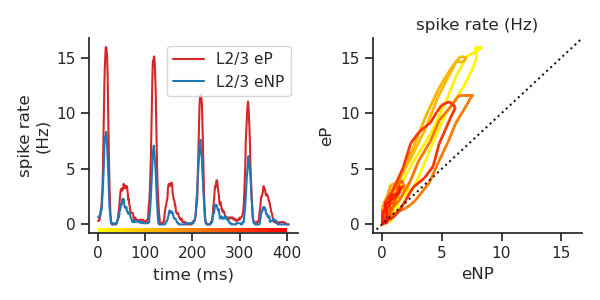

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].plot(times_sr_post_burn_in, sr_1_avg, c='tab:red')
axes[0].plot(times_sr_post_burn_in, sr_2_avg, c='tab:blue')
axes[0].set_xticks(np.arange(0, times_sr_post_burn_in[-1], 100.0))
axes[0].set_ylabel('spike rate\n(Hz)')
axes[0].set_xlabel('time (ms)')
axes[0].legend(['L2/3 eP', 'L2/3 eNP'])
cax = axes[0].inset_axes([0.0, -0.70, 400, 0.40], transform=axes[0].transData)

# now do the same for spike rates
points = np.array([sr_2_avg, sr_1_avg]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(times_sr_post_burn_in.min(), times_sr_post_burn_in.max())
lc = LineCollection(segments, cmap='autumn_r', norm=norm)
# Set the values used for colormapping
lc.set_array(times_sr_post_burn_in)
lc.set_linewidth(2)
line = axes[1].add_collection(lc)
# place colorbar along x-axis of 1st plot
cbar = fig.colorbar(line, cax=cax, orientation='horizontal')
cbar.outline.set_visible(False)
cbar.set_ticks([])

lim_max = np.max([sr_2_avg, sr_1_avg])
lim = [-lim_max * 0.05, lim_max * 1.05]
axes[1].plot(lim, lim, c='k', ls=':')
axes[1].set_title('spike rate (Hz)')
axes[1].set_xlim(lim)
axes[1].set_ylim(lim)
axes[1].set_ylabel('eP')
axes[1].set_xlabel('eNP')

# update y-ticks across subplots - don't use sharey because it'll remove
# y-label from 2nd subplot
ticks = axes[1].get_xticks()
ticks = ticks[np.logical_and(ticks >= lim[0], ticks <= lim[1])]
axes[1].set_yticks(ticks)
axes[0].set_ylim(lim)  # update 1st plot as well
axes[0].set_yticks(ticks)

fig.tight_layout()
plt.show()

In [73]:
# neural representation shift -> classify phasic responders to each stim rep
# !!!note!!!: try this with double the burn_in_time to get a better estimate of
# baseline spike rates
cell_types = ['L2e_1', 'L2e_2']
n_total_cells = np.sum([len(net.gid_ranges[cell_type]) for cell_type in cell_types])
rep_intervals = burn_in_time + np.arange(0, 400, 100)
n_reps = len(rep_intervals)
# trials x cells; first half of cells are from Group 1
spike_counts_baseline = list()
# trials x cells x reps; first half of cells are from Group 1
spike_counts_evoked = list()
# cells x reps x spikes aggr. across trials; first half of cells are from Group 1
spikes_evoked = list()

for trial_idx in range(n_trials):
    spike_gids = np.array(net.cell_response.spike_gids[trial_idx])
    spike_times = np.array(net.cell_response.spike_times[trial_idx])
    sc_baseline_all_cells = list()
    sc_evoked_all_cells = list()
    for cell_type in cell_types:
        for gid in net.gid_ranges[cell_type]:
            spike_times_sel = spike_times[spike_gids == gid]

            # baseline
            sc_baseline = len(spike_times_sel[np.logical_and(
                spike_times_sel >= 0.5 * burn_in_time,
                spike_times_sel < burn_in_time)])
            sc_baseline_all_cells.append(sc_baseline)

            # evoked
            sc_evoked = list()
            for t_start in rep_intervals:
                # count spikes within 50 ms of repetition onset
                spike_times_in_win = spike_times_sel[np.logical_and(
                    spike_times_sel >= t_start,
                    spike_times_sel <= t_start + 50.0)]
                sc_evoked.append(len(spike_times_in_win))
            sc_evoked_all_cells.append(sc_evoked)

    spike_counts_baseline.append(sc_baseline_all_cells)
    spike_counts_evoked.append(sc_evoked_all_cells)

# calculate spike rates
spike_rates_baseline = np.array(spike_counts_baseline) / (burn_in_time * 1e-3)
spike_rates_evoked = np.array(spike_counts_evoked) / (50.0 * 1e-3)

# now get spikes aggregated across trials
spike_gids = np.concatenate(net.cell_response.spike_gids)
spike_times = np.concatenate(net.cell_response.spike_times)
for cell_type in cell_types:
    for gid in net.gid_ranges[cell_type]:
        spike_times_sel = spike_times[spike_gids == gid]
        st_evoked = list()
        for t_start in rep_intervals:
            # get spikes within full repetition window
            spike_times_in_win = spike_times_sel[np.logical_and(
                spike_times_sel >= t_start,
                spike_times_sel <= t_start + 100.0)]
            st_evoked.append(spike_times_in_win - t_start)
        spikes_evoked.append(st_evoked)
spikes_evoked = np.array(spikes_evoked, dtype=object)

print(f'mean L2/3e baseline spike rate: {np.mean(spike_rates_baseline)}')

mean L2/3e baseline spike rate: 0.17534722222222224


In [95]:
responder_cells = np.full((n_total_cells, n_reps), False, dtype=bool)
responder_ranks = np.zeros((n_total_cells, n_reps))

for cell_idx in range(n_total_cells):
    baseline_rates = spike_rates_baseline[:, cell_idx]
    for rep_idx in range(n_reps):
        evoked_rates = spike_rates_evoked[:, cell_idx, rep_idx]
        test_results = wilcoxon(evoked_rates, baseline_rates,
                                alternative='two-sided',
                                zero_method='zsplit')
        if test_results.pvalue < 0.05:
            responder_cells[cell_idx, rep_idx] = True
        responder_ranks[cell_idx, rep_idx] = 1 - test_results.pvalue

print(responder_cells.sum(axis=0))

/home/ryan/anaconda3/envs/hnn_core/lib/python3.9/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


[27 27 23 19]


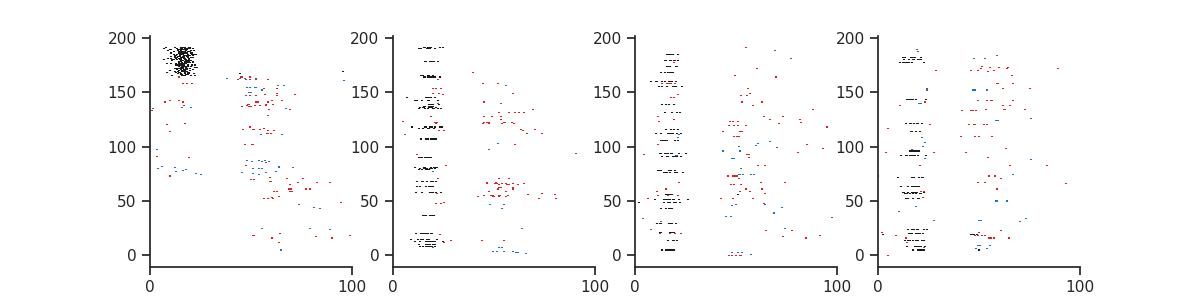

In [98]:
# sort by p-val on first rep
order_idxs = np.argsort(responder_ranks[:, 0])
spikes_evoked_sorted = spikes_evoked[order_idxs, :]

fig, axes = plt.subplots(1, 4, sharex=True, figsize=(12, 3))
for rep_idx in range(n_reps):
    colors = list()
    for rank, cell_idx in zip(responder_ranks[order_idxs, rep_idx], order_idxs):
        if rank < 0.95:
            # first half of cells are from Group 1...
            if cell_idx < n_total_cells / 2:
                colors.append('tab:red')
            else:
                colors.append('tab:blue')
        else:
            colors.append('k')
    axes[rep_idx].eventplot(spikes_evoked_sorted[:, rep_idx], colors=colors)
    axes[rep_idx].set_xlim([0, 100])
    axes[rep_idx].set_xticks([0, 100])
    axes[rep_idx].set_xlabel('time (ms)')


In [ ]:
n_sims = 5

dev_magnitude = -1
n_trials = 1
burn_in_time = 300.0
n_procs = 10
record_vsec = False

for sim_idx in range(n_sims):
    # simulate a random trial from a random network
    rng = np.random.default_rng(sim_idx)
    net, drive_params = sim_dev_spiking(dev_magnitude=dev_magnitude,
                                        n_trials=n_trials,
                                        burn_in_time=burn_in_time,
                                        n_procs=n_procs,
                                        record_vsec=record_vsec,
                                        rng=rng)
    
    # calculate & prepare avg conductance vectors for plotting
    # all GABAergic conductances on L2/3 e cells
    c_total_by_type = get_conductance_timecourse(net,
                                                 cell_types=['L2e_1', 'L2e_2'],
                                                 receptor=['gabaa', 'gabab'],
                                                 src_types=None)
    times = net.cell_response.times
    n_trials = len(net.cell_response.spike_times)
    post_burn_in_idxs = times >= burn_in_time
    times_post_burn_in = times[post_burn_in_idxs] - burn_in_time

    g_1_avg = c_total_by_type['L2e_1'].mean(axis=0) / n_trials
    g_1_avg = g_1_avg[post_burn_in_idxs]
    g_2_avg = c_total_by_type['L2e_2'].mean(axis=0) / n_trials
    g_2_avg = g_2_avg[post_burn_in_idxs]
        